In [1]:
# ==========================================
# 0. INSTALAÇÃO E IMPORTAÇÕES
# ==========================================
# Instala biblioteca para baixar arquivos do Google Drive
!pip install -q gdown

import os
import time
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors
import gdown

print("Bibliotecas importadas com sucesso.")


Bibliotecas importadas com sucesso.


In [2]:
# ---------------------------------------------------------
# 1. PREPARAÇÃO E DOWNLOAD DE DADOS
# ---------------------------------------------------------
def download_data():
    dataset_id = '1Jg8FPCxGPckXMNSlTybxFu5unZCFuW9h'
    gt_id = '10rYRFQAi1AlJDSWAoZK7-SX0D8Kr2oDM'

    if not os.path.exists('dataset.zip') and not os.path.exists('kitti_data'):
        print("Baixando dataset...")
        gdown.download(id=dataset_id, output='dataset.zip', quiet=False)
        print("Extraindo dataset...")
        with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
            zip_ref.extractall('kitti_data')

    if not os.path.exists('ground_truth.npy'):
        print("Baixando Ground Truth...")
        gdown.download(id=gt_id, output='ground_truth.npy', quiet=False)

download_data()

Baixando dataset...


Downloading...
From: https://drive.google.com/uc?id=1Jg8FPCxGPckXMNSlTybxFu5unZCFuW9h
To: /content/dataset.zip
100%|██████████| 18.0M/18.0M [00:00<00:00, 33.5MB/s]


Extraindo dataset...
Baixando Ground Truth...


Downloading...
From: https://drive.google.com/uc?id=10rYRFQAi1AlJDSWAoZK7-SX0D8Kr2oDM
To: /content/ground_truth.npy
100%|██████████| 3.97k/3.97k [00:00<00:00, 13.6MB/s]


In [3]:
# ---------------------------------------------------------
# 2. FUNÇÕES DE LEITURA E FILTRAGEM
# ---------------------------------------------------------
def load_pc(path):
    '''
    Carrega nuvem de pontos manual (sem Trimesh para controle total).
    Realiza a troca de eixos necessária para o KITTI (Y <-> Z).
    '''
    points = []
    try:
        with open(path, 'r') as f:
            for line in f:
                if line.startswith('v '):
                    parts = line.strip().split()
                    # Troca Y por Z para alinhar com o Ground Truth (Z é frente)
                    points.append([float(parts[1]), float(parts[3]), float(parts[2])])
        return np.array(points, dtype=np.float32)
    except Exception as e:
        print(f"Erro ao ler {path}: {e}")
        return np.zeros((0, 3))

def remove_ground(pc, axis=1, cut_percentage=0.75):
    ''' Remove os pontos do chão para melhorar a ancoragem do ICP '''
    sorted_indices = np.argsort(pc[:, axis])
    cut_index = int(len(sorted_indices) * cut_percentage)
    keep_indices = sorted_indices[cut_index:]
    return pc[keep_indices, :]


In [4]:
# ---------------------------------------------------------
# 3. IMPLEMENTAÇÃO DO ICP
# ---------------------------------------------------------

def voxel_grid_sample(points, voxel_size=0.5):
    '''
    Substitui a nuvem densa por um ponto representativo em cada cubo (voxel) 3D.
    Isso uniformiza a densidade e reduz o peso de áreas com muitos pontos repetidos.
    '''
    if len(points) == 0:
        return points

    # 1. Arredonda as coordenadas para o índice do voxel inteiro
    voxel_indices = (points / voxel_size).astype(int)

    # 2. Encontra índices únicos (mantém apenas um ponto por voxel)
    _, unique_indices = np.unique(voxel_indices, axis=0, return_index=True)

    return points[unique_indices]

def best_fit_transform(A, B):
    '''
    Calcula a matriz T (4x4) que alinha A em B usando SVD.
    Esta é a base matemática do registro de corpo rígido.
    '''
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # Correção para reflexão
    if np.linalg.det(R) < 0:
        Vt[2, :] *= -1
        R = np.dot(Vt.T, U.T)

    t = centroid_B.T - np.dot(R, centroid_A.T)

    T = np.identity(4)
    T[:3, :3] = R
    T[:3, 3] = t
    return T

def icp(source, target, max_iterations=100, tolerance=1e-6, dist_threshold=0.5):
    '''
    Algoritmo Iterative Closest Point.
    Inclui rejeição de outliers para robustez.
    '''
    src = source.copy()
    dst = target.copy()

    src_h = np.ones((src.shape[0], 4))
    src_h[:, :3] = src
    T_final = np.eye(4)
    prev_error = float('inf')

    # KD-Tree para encontrar vizinhos mais próximos (permitido: sklearn/scipy)
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='kd_tree').fit(dst)

    for i in range(max_iterations):
        # A. Encontrar correspondências
        src_curr = src_h[:, :3]
        distances, indices = nbrs.kneighbors(src_curr)
        distances = distances.ravel()
        indices = indices.ravel()

        # B. Rejeição de Outliers (Pontos sem par próximo são ignorados)
        mask = distances < dist_threshold

        # Segurança: se sobrarem poucos pontos, para para não quebrar o SVD
        if np.sum(mask) < 50:
            break

        src_good = src_curr[mask]
        dst_good = dst[indices][mask]

        # C. Calcular Transformação (SVD)
        T_step = best_fit_transform(src_good, dst_good)

        # D. Aplicar e Acumular
        src_h = (np.dot(T_step, src_h.T)).T
        T_final = np.dot(T_step, T_final)

        # E. Convergência
        mean_error = np.mean(distances[mask])
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    return T_final

In [5]:
# ---------------------------------------------------------
# 4. EXECUÇÃO DA TRAJETÓRIA
# ---------------------------------------------------------
scan_files = sorted([os.path.join(r, f) for r, d, fs in os.walk('kitti_data') for f in fs if f.endswith('.obj')])

print(f"Processando {len(scan_files)} scans...")

current_pose = np.eye(4)
estimated_path = [current_pose]
last_T_rel = np.eye(4) # Modelo de velocidade constante

start_time = time.time()

for i in range(len(scan_files) - 1):
    # 1. Carregar e Filtrar
    source_raw = load_pc(scan_files[i])
    target_raw = load_pc(scan_files[i+1])

    # A. Remove o chão (75% dos pontos mais baixos)
    source_no_ground = remove_ground(source_raw, axis=1, cut_percentage=0.75)
    target_no_ground = remove_ground(target_raw, axis=1, cut_percentage=0.75)

    # B. Aplica Voxel Grid (Uniformiza a densidade - Voxel de 0.5m)
    # Isso ajuda o ICP a focar em estruturas grandes em vez de detalhes densos irrelevantes
    source_cloud = voxel_grid_sample(source_no_ground, voxel_size=0.5)
    target_cloud = voxel_grid_sample(target_no_ground, voxel_size=0.5)

    # 2. Chute Inicial (Aplicar velocidade anterior)
    R_prev = last_T_rel[:3, :3]
    t_prev = last_T_rel[:3, 3]
    source_guess = np.dot(source_cloud, R_prev.T) + t_prev

    # 3. ICP
    # dist_threshold=0.5 mantém a rejeição rigorosa de outliers
    T_correction = icp(source_guess, target_cloud, max_iterations=100, tolerance=1e-6, dist_threshold=0.5)

    # 4. Acumular movimento (Chute + Correção do ICP)
    T_rel = np.dot(T_correction, last_T_rel)

    # 5. Atualizar Pose Global (Inversa pois movemos o mundo em relação ao carro)
    current_pose = np.dot(current_pose, np.linalg.inv(T_rel))
    last_T_rel = T_rel

    estimated_path.append(current_pose)
    print(f"Scan {i} -> {i+1} processado. Pontos usados: {len(source_cloud)}")

print(f"Concluído em {time.time() - start_time:.2f} segundos.")
estimated_path = np.array(estimated_path)

Processando 30 scans...
Scan 0 -> 1 processado. Pontos usados: 1000
Scan 1 -> 2 processado. Pontos usados: 990
Scan 2 -> 3 processado. Pontos usados: 981
Scan 3 -> 4 processado. Pontos usados: 984
Scan 4 -> 5 processado. Pontos usados: 932
Scan 5 -> 6 processado. Pontos usados: 905
Scan 6 -> 7 processado. Pontos usados: 894
Scan 7 -> 8 processado. Pontos usados: 900
Scan 8 -> 9 processado. Pontos usados: 785
Scan 9 -> 10 processado. Pontos usados: 790
Scan 10 -> 11 processado. Pontos usados: 792
Scan 11 -> 12 processado. Pontos usados: 848
Scan 12 -> 13 processado. Pontos usados: 937
Scan 13 -> 14 processado. Pontos usados: 1033
Scan 14 -> 15 processado. Pontos usados: 1083
Scan 15 -> 16 processado. Pontos usados: 1090
Scan 16 -> 17 processado. Pontos usados: 1102
Scan 17 -> 18 processado. Pontos usados: 1082
Scan 18 -> 19 processado. Pontos usados: 1149
Scan 19 -> 20 processado. Pontos usados: 1142
Scan 20 -> 21 processado. Pontos usados: 1170
Scan 21 -> 22 processado. Pontos usados: 


RESULTADOS FINAIS
Posição Final Real (GT):     [-1.436633  -0.8456208 25.59694  ]
Posição Final Estimada:      [-1.20782817  0.12449632 24.90331414]
Erro de Posição Final:       1.2143 metros
----------------------------------------
Matriz de Transformação Final (Coordenadas Homogêneas):
[[ 9.98343651e-01 -5.79888250e-04 -5.75292834e-02 -1.20782817e+00]
 [ 7.25560155e-04  9.99996584e-01  2.51127942e-03  1.24496322e-01]
 [ 5.75276305e-02 -2.54886082e-03  9.98340661e-01  2.49033141e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


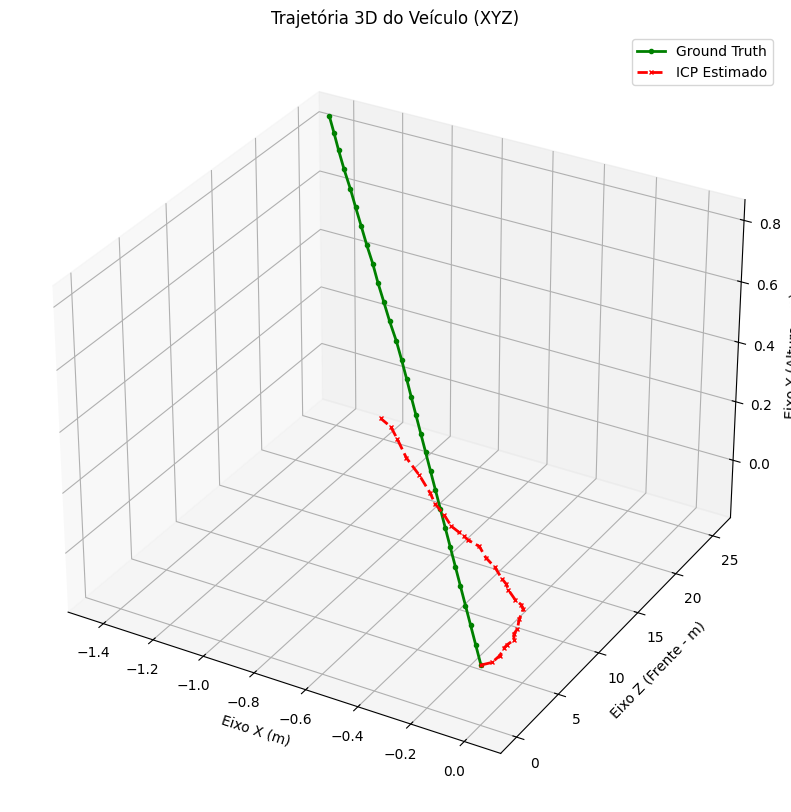

In [6]:
# ---------------------------------------------------------
# 5. RESULTADOS E PLOT 3D
# ---------------------------------------------------------
gt_poses = np.load('ground_truth.npy')

# Extrair coordenadas X, Y, Z
est_x, est_y, est_z = estimated_path[:, 0, 3], estimated_path[:, 1, 3], estimated_path[:, 2, 3]
gt_x, gt_y, gt_z = gt_poses[:, 0, 3], gt_poses[:, 1, 3], gt_poses[:, 2, 3]

# Cálculo do Erro Euclidiano Final
final_error = np.linalg.norm(gt_poses[-1, :3, 3] - estimated_path[-1, :3, 3])

print("\n" + "="*40)
print("RESULTADOS FINAIS")
print("="*40)
print(f"Posição Final Real (GT):     {gt_poses[-1, :3, 3]}")
print(f"Posição Final Estimada:      {estimated_path[-1, :3, 3]}")
print(f"Erro de Posição Final:       {final_error:.4f} metros")
print("-" * 40)
print("Matriz de Transformação Final (Coordenadas Homogêneas):")
print(estimated_path[-1])
print("="*40)

# --- PLOT 3D OBRIGATÓRIO ---
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plotar Ground Truth
ax.plot(gt_x, gt_z, -gt_y, c='green', label='Ground Truth', linewidth=2, marker='o', markersize=3)

# Plotar Estimativa (Invertemos Y no plot apenas para melhor visualização visual se necessário,
# mas os dados brutos estão corretos. Normalmente em 3D plots de carros: X=Lado, Y=Cima, Z=Frente)
ax.plot(est_x, est_z, -est_y, c='red', label='ICP Estimado', linewidth=2, linestyle='--', marker='x', markersize=3)

ax.set_title('Trajetória 3D do Veículo (XYZ)')
ax.set_xlabel('Eixo X (m)')
ax.set_ylabel('Eixo Z (Frente - m)')
ax.set_zlabel('Eixo Y (Altura - m)')
ax.legend()
plt.show()